# **Regression with neural networks**

In this example, we use a dataset documenting housing prices in the Pacific Heighs section of San Francisco and train a neural network to predict what a dwelling will sell for given the number of rooms, the square, and other factors.

In [4]:
import pandas as pd
import seaborn as sns

sns.set()
%matplotlib inline

Load dataset and examine its content and structure

In [5]:
url = 'https://raw.githubusercontent.com/jeffprosise/ML.NET/master/MLN-MultipleRegression/MLN-MultipleRegression/Data/pacific-heights.csv'
df = pd.read_csv(url)
df.head()

,address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zipcode
0,2243 Franklin St,2.0,2,1463,2/5/2016,1950000,37.795139,-122.425309,Pacific Heights,7,Condominium,1900,94109
1,2002 Pacific Ave APT 4,3.5,3,3291,1/22/2016,4200000,37.794429,-122.428513,Pacific Heights,7,Condominium,1961,94109
2,1945 Washington St APT 411,1.0,1,653,12/16/2015,665000,37.792472,-122.425281,Pacific Heights,3,Condominium,1987,94109
3,1896 Pacific Ave APT 802,2.5,2,2272,12/17/2014,2735000,37.794706,-122.426347,Pacific Heights,6,Condominium,1924,94109
4,1840 Washington St APT 603,1.0,1,837,12/2/2015,1050000,37.793212,-122.423744,Pacific Heights,3,Condominium,2012,94109


How many rows and columns does the dataset contain?

In [6]:
df.shape

(439, 13)

Make sure there are no missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        439 non-null    object 
 1   bathrooms      439 non-null    float64
 2   bedrooms       439 non-null    int64  
 3   finishedsqft   439 non-null    int64  
 4   lastsolddate   439 non-null    object 
 5   lastsoldprice  439 non-null    int64  
 6   latitude       439 non-null    float64
 7   longitude      439 non-null    float64
 8   neighborhood   439 non-null    object 
 9   totalrooms     439 non-null    int64  
 10  usecode        439 non-null    object 
 11  yearbuilt      439 non-null    int64  
 12  zipcode        439 non-null    int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 44.7+ KB


Call `corr()` on the DataFrame that have a correlation less than 0.2 as well as the latitude and longitude columns, which are roughly incorporated in the zip code. Also one-hot-encode the values in the 'usercode' and 'zipcode' columns so they can be included in the correlation (and in the model). It is easy to imagine that the dwelling's type and location could have an impact on the selling price.

In [8]:
df = df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode', 'zipcode', 'lastsoldprice']]
df = pd.get_dummies(df, columns=['usecode', 'zipcode'])
df.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,lastsoldprice,usecode_Condominium,usecode_Cooperative,usecode_Duplex,usecode_MultiFamily2To4,usecode_SingleFamily,usecode_Townhouse,zipcode_94109,zipcode_94115,zipcode_94123
0,2.0,2,1463,7,1950000,1,0,0,0,0,0,1,0,0
1,3.5,3,3291,7,4200000,1,0,0,0,0,0,1,0,0
2,1.0,1,653,3,665000,1,0,0,0,0,0,1,0,0
3,2.5,2,2272,6,2735000,1,0,0,0,0,0,1,0,0
4,1.0,1,837,3,1050000,1,0,0,0,0,0,1,0,0


Now run the correlation again.

In [9]:
corr_matrix = df.corr()
corr_matrix['lastsoldprice'].sort_values(ascending=False)

lastsoldprice              1.000000
finishedsqft               0.840864
bathrooms                  0.768179
totalrooms                 0.670726
usecode_SingleFamily       0.638482
bedrooms                   0.606579
zipcode_94123              0.228418
zipcode_94115              0.071123
usecode_Duplex             0.006292
usecode_MultiFamily2To4   -0.019009
usecode_Townhouse         -0.025467
usecode_Cooperative       -0.025556
zipcode_94109             -0.243927
usecode_Condominium       -0.598575
Name: lastsoldprice, dtype: float64

Remove the use-code columns that have little bearing on the output.

In [10]:
df = df.drop(['usecode_Duplex', 'usecode_MultiFamily2To4', 'usecode_Townhouse', 'usecode_Cooperative'], axis=1)
df.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,lastsoldprice,usecode_Condominium,usecode_SingleFamily,zipcode_94109,zipcode_94115,zipcode_94123
0,2.0,2,1463,7,1950000,1,0,1,0,0
1,3.5,3,3291,7,4200000,1,0,1,0,0
2,1.0,1,653,3,665000,1,0,1,0,0
3,2.5,2,2272,6,2735000,1,0,1,0,0
4,1.0,1,837,3,1050000,1,0,1,0,0


Use Seaborn's handy pairplot function to visualize the relationships between non-categorical variables.

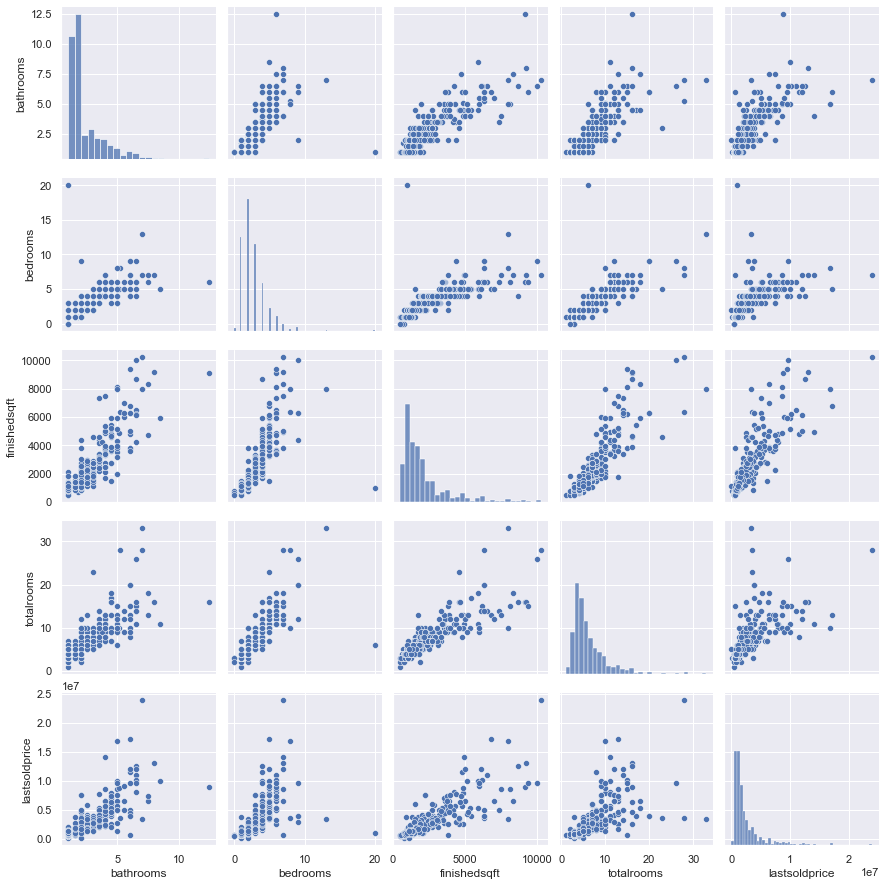

In [12]:
sns.pairplot(df[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'lastsoldprice']]);

Split the dataset fro training and testing.

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop('lastsoldprice', axis=1)
y = df['lastsoldprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now build a neural network containing two hidden layers and train it with the training data.

In [17]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=9, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20)

Epoch 1/100
18/18 [==============================] - 0s 16ms/step - loss: 2499423.2500 - mae: 2499423.2500 - val_loss: 2591313.7500 - val_mae: 2591313.7500
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 2497812.0000 - mae: 2497812.0000 - val_loss: 2589275.5000 - val_mae: 2589275.5000
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 2495159.5000 - mae: 2495159.5000 - val_loss: 2585611.0000 - val_mae: 2585611.0000
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 2490462.0000 - mae: 2490462.0000 - val_loss: 2579261.2500 - val_mae: 2579261.2500
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 2482364.2500 - mae: 2482364.2500 - val_loss: 2569084.0000 - val_mae: 2569084.0000
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 2470053.7500 - mae: 2470053.7500 - val_loss: 2553394.2500 - val_mae: 2553394.2500
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - lo

Plot the training accuracy and validation accuracy over time

[]

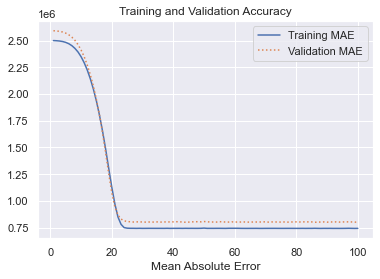

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

Get the coefficient of determination (R2) to determine how accurate the model is.

In [22]:
from sklearn.metrics import r2_score

r2_score(y_test, model.predict(X_test))

0.6278747415678658

Show other accuracy metrics.

In [23]:
scores = model.evaluate(X_test, y_test, verbose=8)

for i in range(0, len(scores)):
    print(model.metrics_names[i] + ': ' + str(scores[i]))

loss: 802235.8125
mae: 802235.8125


In [24]:
import numpy as np

bathrooms = 1
bedrooms = 1
finished_sqft = 1040
total_rooms = 4
usecode_Condominium = 1
usecode_SingleFamily = 0
zipcode_94109 = 0
zipcode_94115 = 1
zipcode_94123 = 0

model.predict(np.array([[bathrooms, bedrooms, finished_sqft, total_rooms, usecode_Condominium, usecode_SingleFamily, zipcode_94109, zipcode_94115, zipcode_94123]]))

array([[1082104.1]], dtype=float32)